In [ ]:
import sys
import re
import numpy as np
import pandas as pd
from pprint import pprint
import math
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
# from gensim.utils import lemmatize, simple_preprocess
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['amp','gt','look', 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


# Loading tweet data
### Display the first 5 records.
### Also print the shape of dataframe.

In [ ]:
# Import dataset from google drive (for google colab)
from google.colab import drive
drive.mount('/content/drive')
tweets = pd.read_csv('/content/drive/My Drive/tweets/tweets.csv')
#Import tweets dataset from local
# tweets = pd.read_csv('./tweets/tweets.csv')
# print(tweets.shape)
# tweets.head()

Mounted at /content/drive


### Show the distribution of tweets based on document length

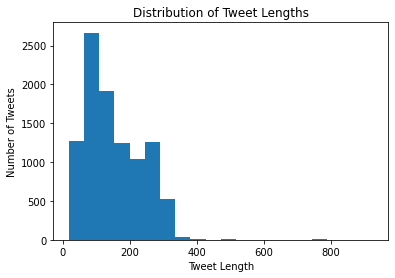

In [ ]:
tweets['text_length'] = tweets['text'].str.len()
plt.hist(tweets['text_length'], bins=20)
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweet Lengths')
plt.show()

### Print the statistics of the dataset

In [ ]:
display(tweets['text_length'].describe().round(2))


count    10001.0
mean       151.9
std         83.5
min         18.0
25%         84.0
50%        132.0
75%        215.0
max        926.0
Name: text_length, dtype: float64

### Tokenise the tweets and remove any emails, newline character, remove single line quote

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
        sent = re.sub(r'\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub(r'\s+', ' ', sent)  # remove newline chars
        sent = re.sub(r"\'", "", sent)  # remove single quotes
        sent = re.sub(r'http\S+', '', sent) # remove hypertext link
        sent = emoji_pattern.sub(r'', sent) # remove emoji
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

In [ ]:
text = tweets.text.values.tolist()
textWords = list(sent_to_words(text))
print(textWords)

[['criterion', 'certainly', 'have', 'us', 'rights', 'to', 'the', 'restoration', 'but', 'very', 'unlikely', 'they', 'have', 'any', 'claim', 'to', 'uk', 'uhd', 'rights', 'alone', 'this', 'seems', 'more', 'like', 'cost', 'analysis', 'decision', 'by', 'the', 'bfi', 'or', 'else', 'they', 'determined', 'the', 'new', 'restoration', 'doesnt', 'merit', 'for', 'home', 'release', 'which', 'would', 'be', 'odd'], ['china', 'chinese', 'foreign', 'ministry', 'said', 'that', 'this', 'is', 'weather', 'balloon', 'that', 'had', 'deviated', 'from', 'its', 'course', 'the', 'pentagon', 'said', 'that', 'it', 'is', 'not', 'military', 'threat', 'poland', 'canada', 'india', 'australia', 'london', 'kyiv', 'dubai', 'israel', 'newyorkcity', 'toronto', 'iran'], ['as', 'they', 'began', 'to', 'understand', 'the', 'children', 'operational', 'schemes', 'they', 'were', 'more', 'purposeful', 'in', 'their', 'visits', 'and', 'what', 'they', 'collected', 'and', 'offered', 'to', 'the', 'children', 'love', 'this', 'child', 'l

### Lets see how the preprocessing affects the length of the document by using -
##### A. Visualisation

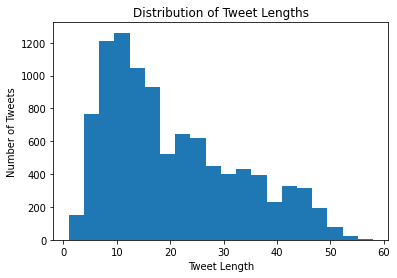

In [ ]:
processedTokens = [len(doc) for doc in textWords]

plt.hist(pd.DataFrame(processedTokens), bins=20)
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweet Lengths')
plt.show()

In [ ]:
pd.DataFrame(processedTokens).describe()

0
count  10001.000000
mean      20.417758
std       12.390628
min        1.000000
25%       10.000000
50%       17.000000
75%       29.000000
max       58.000000

##### B. Statistics

# Building bigram, trigram models and lemmatization

In [ ]:
#Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.
# Build the bigram and trigram models
bigram = gensim.models.Phrases(textWords, min_count=3, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[textWords], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

import en_core_web_sm
nlp = en_core_web_sm.load()

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
   # nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

/usr/local/lib/python3.9/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
processedTweets = process_words(textWords)

In [ ]:
print(processedTweets)

[['criterion', 'certainly', 'restoration', 'unlikely', 'claim', 'alone', 'cost', 'analysis', 'decision', 'bfi', 'else', 'determine', 'new', 'restoration', 'merit', 'home', 'release', 'odd'], ['weather', 'deviate', 'course', 'military', 'dubai'], ['begin', 'understand', 'child', 'operational', 'scheme', 'purposeful', 'visit', 'collect', 'offer', 'child', 'love', 'child', 'lead', 'influence'], ['excess_death', 'death', 'excess_death', 'register', 'wale', 'week', 'end', 'th', 'year', 'average', 'happening'], ['seychelle'], ['horse_race', 'history', 'today', 'race', 'day', 'horse_race', 'news', 'history', 'extensive', 'horse', 'bet', 'news', 'archive', 'present', 'thoroughbred', 'race', 'action', 'australian', 'overseas', 'racing', 'news', 'history'], ['ridiculous', 'service', 'store', 'remember', 'order', 'manager', 'treat', 'disrespect', 'staff', 'wait', 'refund', 'apparently', 'promise'], ['live', 'stream', 'watch', 'match', 'chelsea', 'head', 'head', 'start', 'stadium', 'match', 'part'

# Creating LDA model using gensim package

In [ ]:

# Create Dictionary
wordDictionary = corpora.Dictionary(processedTweets)
print(len(wordDictionary))
# Create Corpus: Term Document Frequency
tweetCorpus = [wordDictionary.doc2bow(text) for text in processedTweets]

# Build LDA model
co=[]
perp=[]
kld =[]
for topic in range(8,14):
  tweetsModel = gensim.models.ldamodel.LdaModel(corpus=tweetCorpus,
                                            id2word=wordDictionary,
                                            num_topics=topic,
                                            random_state=5000,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)

  perplexity = tweetsModel.log_perplexity(tweetCorpus)
  perp.append(perplexity)
  coherence_model_lda = CoherenceModel(model=tweetsModel, texts=processedTweets, dictionary=wordDictionary, coherence='c_v')
  coherence_score = coherence_model_lda.get_coherence()
  co.append(coherence_score)
  kld.append(np.average(tweetsModel.diff(tweetsModel)[0]))


12805


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

[0.3260030944013636, 0.344203104903108, 0.3726048292296642, 0.3727747735054556, 0.4121914920405099, 0.4229663707444055]


Text(0, 0.5, 'Coherence Score')

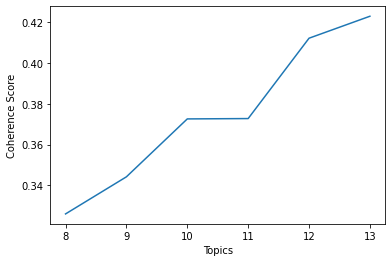

In [ ]:
print(co)
plt.plot(range(8,14), co)
plt.xlabel("Topics")
plt.ylabel("Coherence Score")

Text(0, 0.5, 'Perplexity')

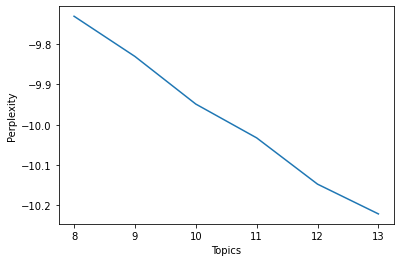

In [ ]:
plt.plot(range(8,14), perp)
plt.xlabel("Topics")
plt.ylabel("Perplexity")

Text(0, 0.5, 'KL Divergence')

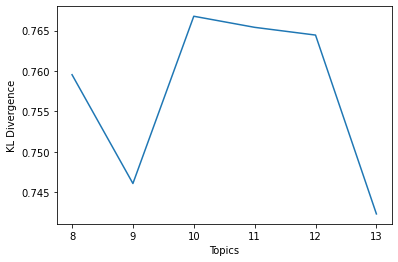

In [ ]:
plt.plot(range(8,14), kld)
plt.xlabel("Topics")
plt.ylabel("KL Divergence")

In [ ]:
tweetsModel = gensim.models.ldamodel.LdaModel(corpus=tweetCorpus,
                                            id2word=wordDictionary,
                                            num_topics=9,
                                            random_state=5000,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)
 # print all topics
tweetsModel.show_topics()

# print topic 28
tweetsModel.print_topic(-1, topn=20)

# another way
for i in range(0, tweetsModel.num_topics-1):
     print(tweetsModel.print_topic(i))

# and another way, only prints top words
for t in range(0, tweetsModel.num_topics):
    print(  'topic {}: '.format(t) + ', '.join([str(v[1]) for v in tweetsModel.show_topic(t, 20)]))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

0.032*"work" + 0.030*"day" + 0.020*"well" + 0.015*"scotland" + 0.015*"read" + 0.015*"news" + 0.014*"people" + 0.012*"buy" + 0.012*"set" + 0.010*"hard"
0.040*"time" + 0.037*"people" + 0.022*"leave" + 0.022*"show" + 0.019*"love" + 0.019*"year" + 0.018*"country" + 0.018*"watch" + 0.015*"thing" + 0.014*"first"
0.085*"jar" + 0.085*"symon" + 0.085*"spender" + 0.014*"bad" + 0.013*"check" + 0.010*"big" + 0.008*"life" + 0.008*"care" + 0.007*"follow" + 0.006*"night"
0.039*"labour" + 0.015*"government" + 0.014*"city" + 0.012*"part" + 0.011*"link" + 0.011*"woman" + 0.010*"fund" + 0.009*"money" + 0.008*"black" + 0.008*"find"
0.022*"pay" + 0.022*"live" + 0.020*"play" + 0.016*"back" + 0.015*"world" + 0.014*"stop" + 0.014*"week" + 0.014*"ticket" + 0.012*"next" + 0.012*"issue"
0.044*"new" + 0.017*"wale" + 0.012*"hear" + 0.011*"wait" + 0.010*"cost" + 0.009*"home" + 0.008*"match" + 0.008*"lie" + 0.007*"decision" + 0.007*"service"
0.025*"tory" + 0.023*"still" + 0.020*"vote" + 0.018*"give" + 0.018*"conserv

/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

# Assigning topics to each tweet

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
tweet_topic_sents_keywords = format_topics_sentences(ldamodel=tweetsModel, corpus=tweetCorpus, texts=processedTweets)

# Format
tweet_dominant_topic = tweet_topic_sents_keywords.reset_index()
tweet_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
tweet_dominant_topic.head(10)

<ipython-input-240-aefd7c72c831>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-240-aefd7c72c831>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               5              0.7819   
1            1               3              0.6562   
2            2               8              0.6858   
3            3               6              0.3451   
4            4               0              0.1111   
5            5               0              0.7038   
6            6               5              0.6759   
7            7               5              0.6790   
8            8               2              0.3277   
9            9               5              0.3332   

                                                                  Keywords  \
0         new, wale, hear, wait, cost, home, match, lie, decision, service   
1    labour, government, city, part, link, woman, fund, money, black, find   
2   support, new_york, really, last, let, mean, always, reason, plan, club   
3  tory, still, vote, give, conservative, never, year, party, happen, sell   
4            work, day, well, scotland, read, news, people, buy, set, hard   
5            work, day, well, scotland, read, news, people, buy, set, hard   
6         new, wale, hear, wait, cost, home, match, lie, decision, service   
7         new, wale, hear, wait, cost, home, match, lie, decision, service   
8          jar, symon, spender, bad, check, big, life, care, follow, night   
9         new, wale, hear, wait, cost, home, match, lie, decision, service   

                                                                                                  Text  
0  [criterion, certainly, restoration, unlikely, claim, alone, cost, analysis, decision, bfi, else,...  
1                                                         [balloon, deviate, course, military, threat]  
2  [understand, child, operational, scheme, purposeful, visit, collect, offer, child, love, child, ...  
3          [excess_death, wale, death, excess_death, register, wale, week, end, year, average, happen]  
4                                                                                                   []  
5  [horse_race, history, today, racing, th_february, day, horse_race, news, history, extensive, hor...  
6     [ridiculous, service, store, remember, order, manager, treat, wait, refund, apparently, promise]  
7                                      [live, stream, premier_league, match, head, start, match, part]  
8                                                                        [check, snake, eye, dvd_ebay]  
9  [fable, city, metaphysical, foundation, gradually, abandon, polity, become, ripe, takeover, icar...

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

tweet_sent_topics_sorteddf_mallet = pd.DataFrame()
tweet_sent_topics_outdf_grpd = tweet_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in tweet_sent_topics_outdf_grpd:
    tweet_sent_topics_sorteddf_mallet = pd.concat([tweet_sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
tweet_sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
tweet_sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
tweet_sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0          0              0.9259   
1          1              0.9259   
2          2              0.8889   
3          3              0.8889   
4          4              0.9012   
5          5              0.9407   
6          6              0.9192   
7          7              0.8949   
8          8              0.9444   

                                                                  Keywords  \
0            work, day, well, scotland, read, news, people, buy, set, hard   
1      time, people, leave, show, love, year, country, watch, thing, first   
2          jar, symon, spender, bad, check, big, life, care, follow, night   
3    labour, government, city, part, link, woman, fund, money, black, find   
4            pay, live, play, back, world, stop, week, ticket, next, issue   
5         new, wale, hear, wait, cost, home, match, lie, decision, service   
6  tory, still, vote, give, conservative, never, year, party, happen, sell   
7           great, man, way, start, much, keep, tomorrow, lose, race, full   
8   support, new_york, really, last, let, mean, always, reason, plan, club   

                                                                                   Representative Text  
0  [master, astrology, astrologer, holypsychic, astrology, palmreading, palmreader, horoscopereader...  
1                      [baby, tear, hand, pace, episode, leave, hand, shancai, scene, continue, watch]  
2                                        [westfield, brocton, silver, creek, silver, creek, westfield]  
3                                         [absolutely, sick, steroid, crazy, hungrie, crazy, sadbrain]  
4                                                [blimey, ticket, next, week, email, fly, delay, town]  
5  [dresnoop, icecube, cent, djwhookid, jloqueenb, taylorswift, virginfamily, adida, northeast, lee...  
6  [worthless, tory, immigration, policy, tolerance, illegal, immigration, contribute, blight, soci...  
7  [back, back, lesnar, lose, undertaker, lose, back, lesnar, lesnar, benoit, survivor, back, lesna...  
8  [seriously, sadistic, expose, sissy, whore, deprave, sissy, expose, sissyexposed, exposeme, blac...

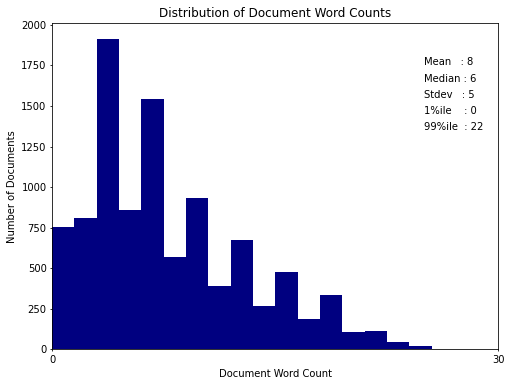

In [ ]:
doc_lens = [len(d) for d in tweet_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,6))
plt.hist(doc_lens,bins=20, color='navy')
plt.text(25, 1750, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(25, 1650, "Median : " + str(round(np.median(doc_lens))))
plt.text(25, 1550, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(25, 1450, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(25, 1350, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 30), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=2)
plt.xticks(np.linspace(0,30,2))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=12))
plt.show()

<ipython-input-243-24a3bdcd9e3c>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-243-24a3bdcd9e3c>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-243-24a3bdcd9e3c>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-243-24a3bdcd9e3c>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens,

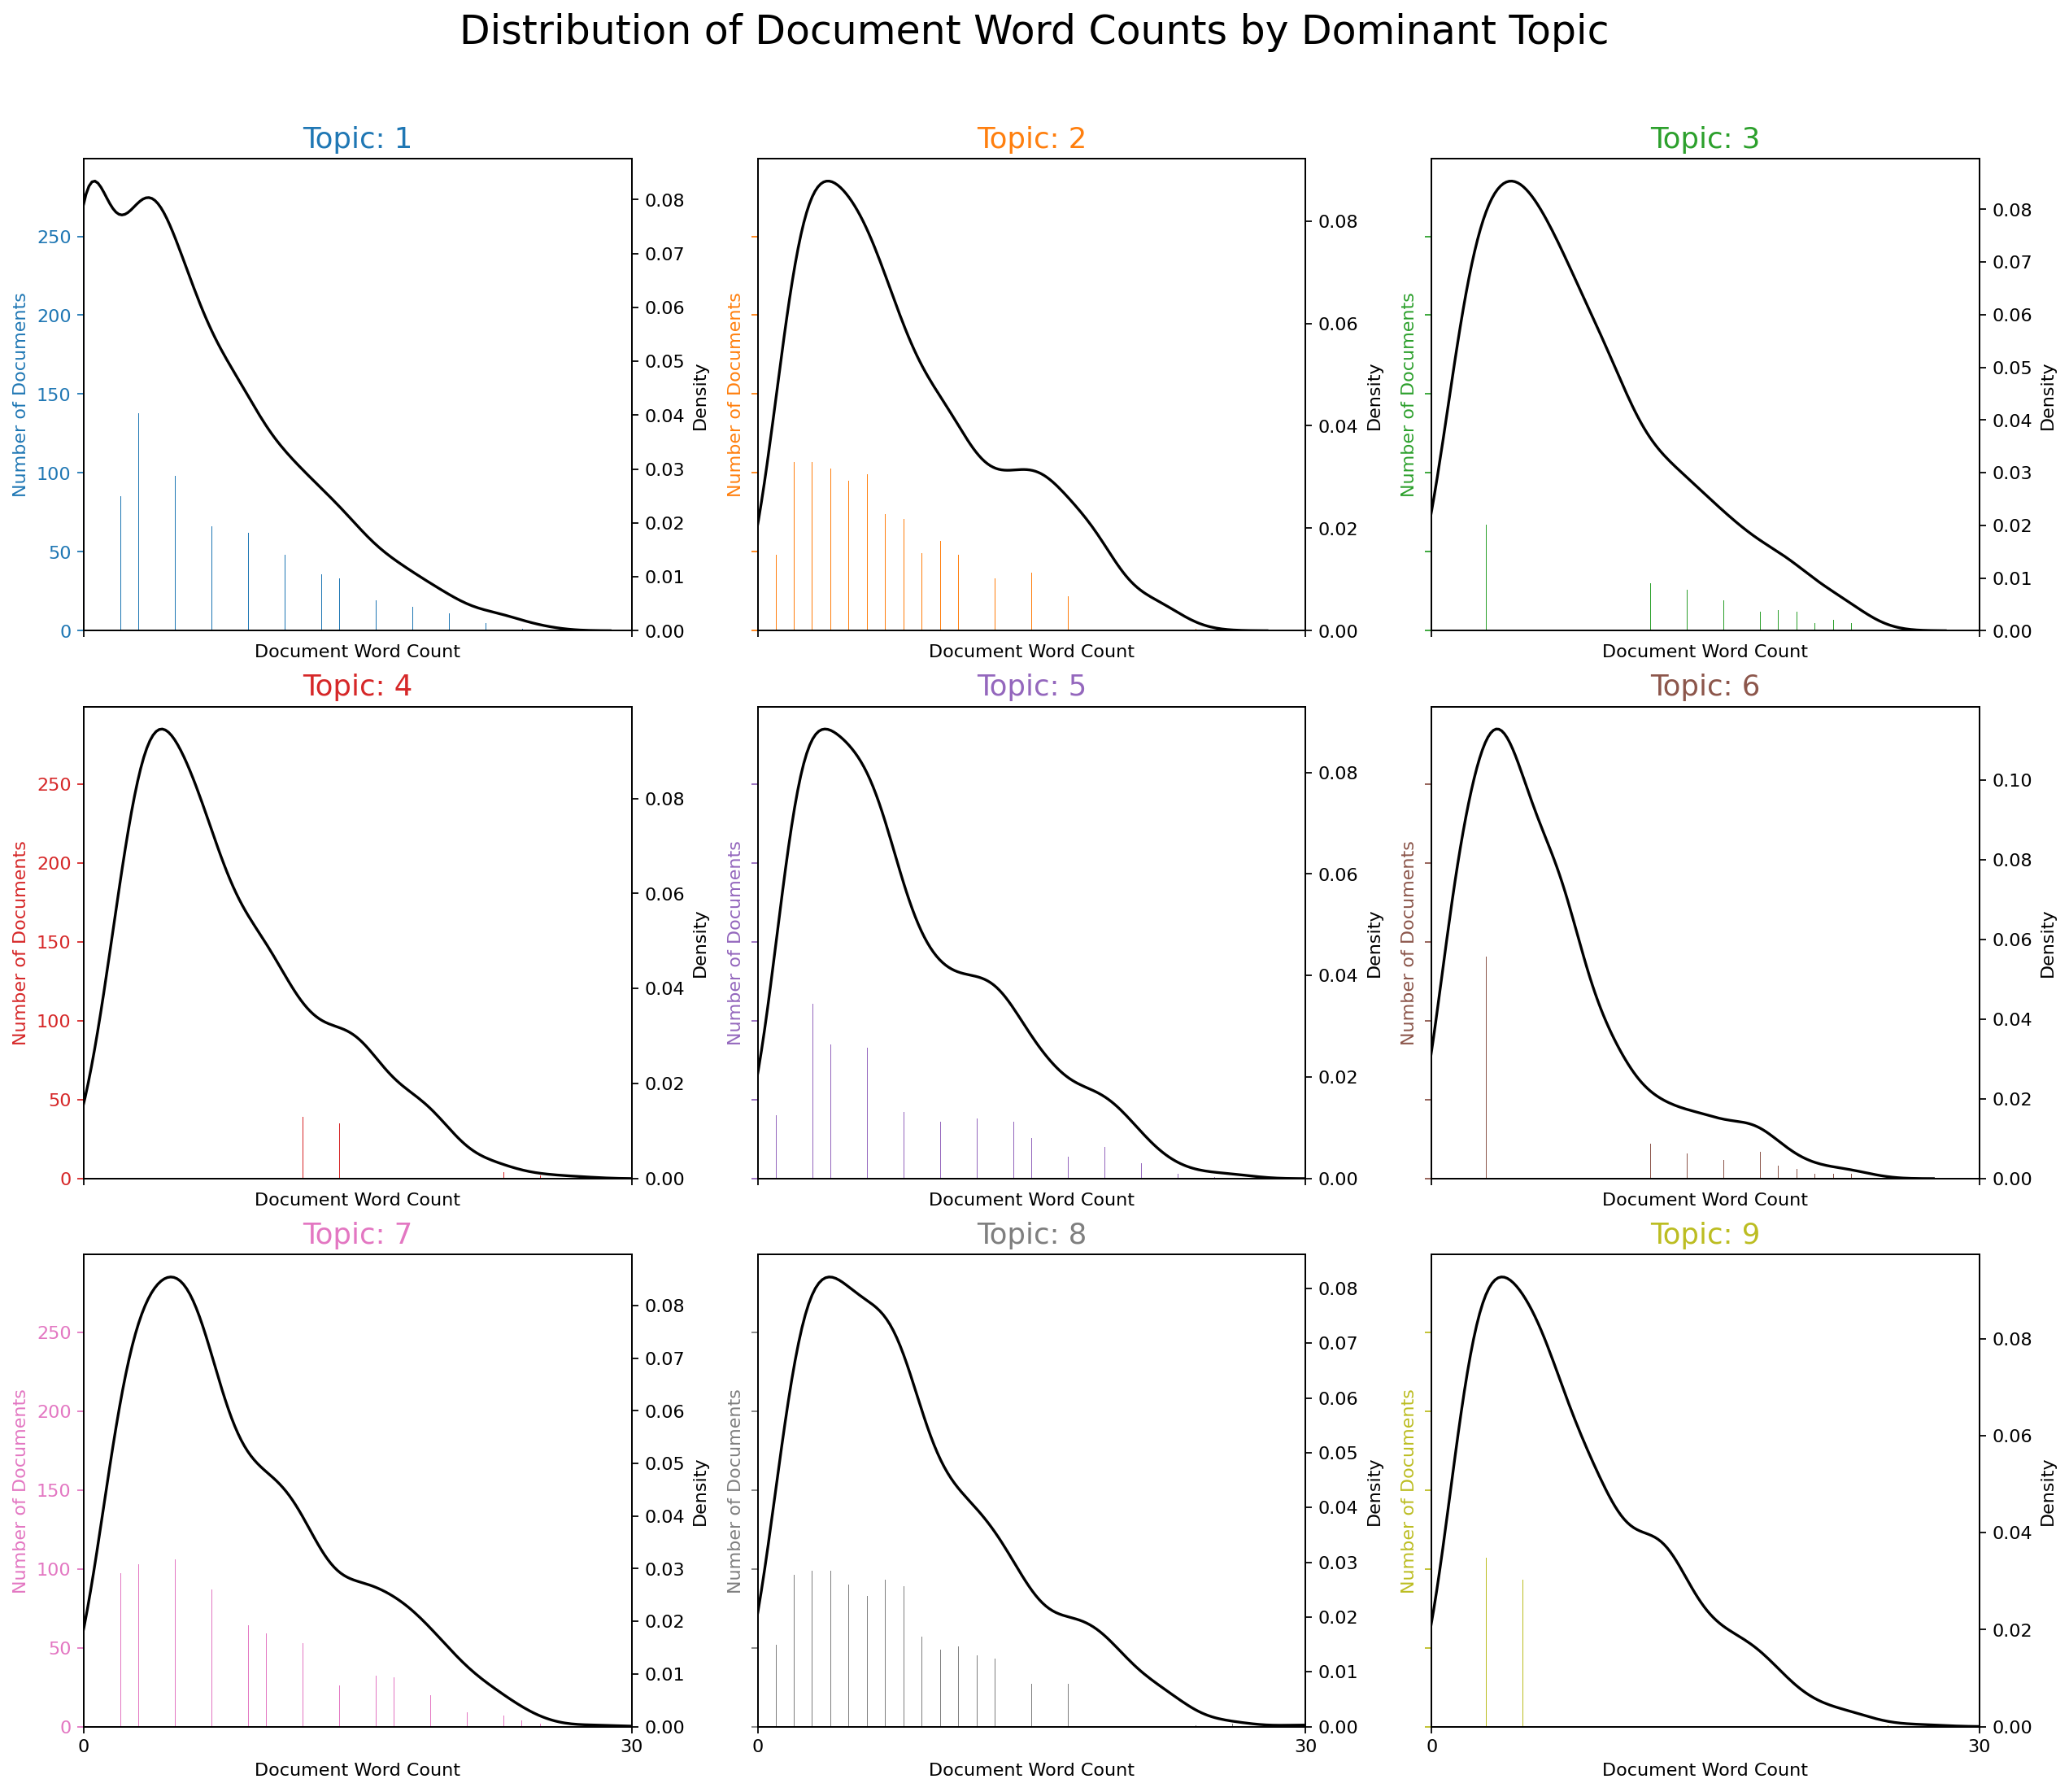

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    tweet_dominant_topic_sub = tweet_dominant_topic.loc[tweet_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in tweet_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 20), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i+1), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,30,2))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

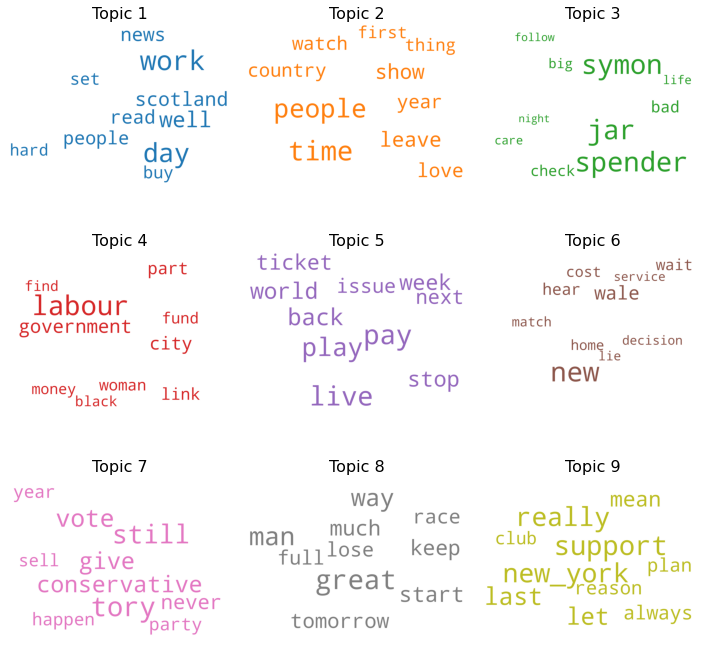

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = tweetsModel.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<ipython-input-246-4cb04de4f950>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


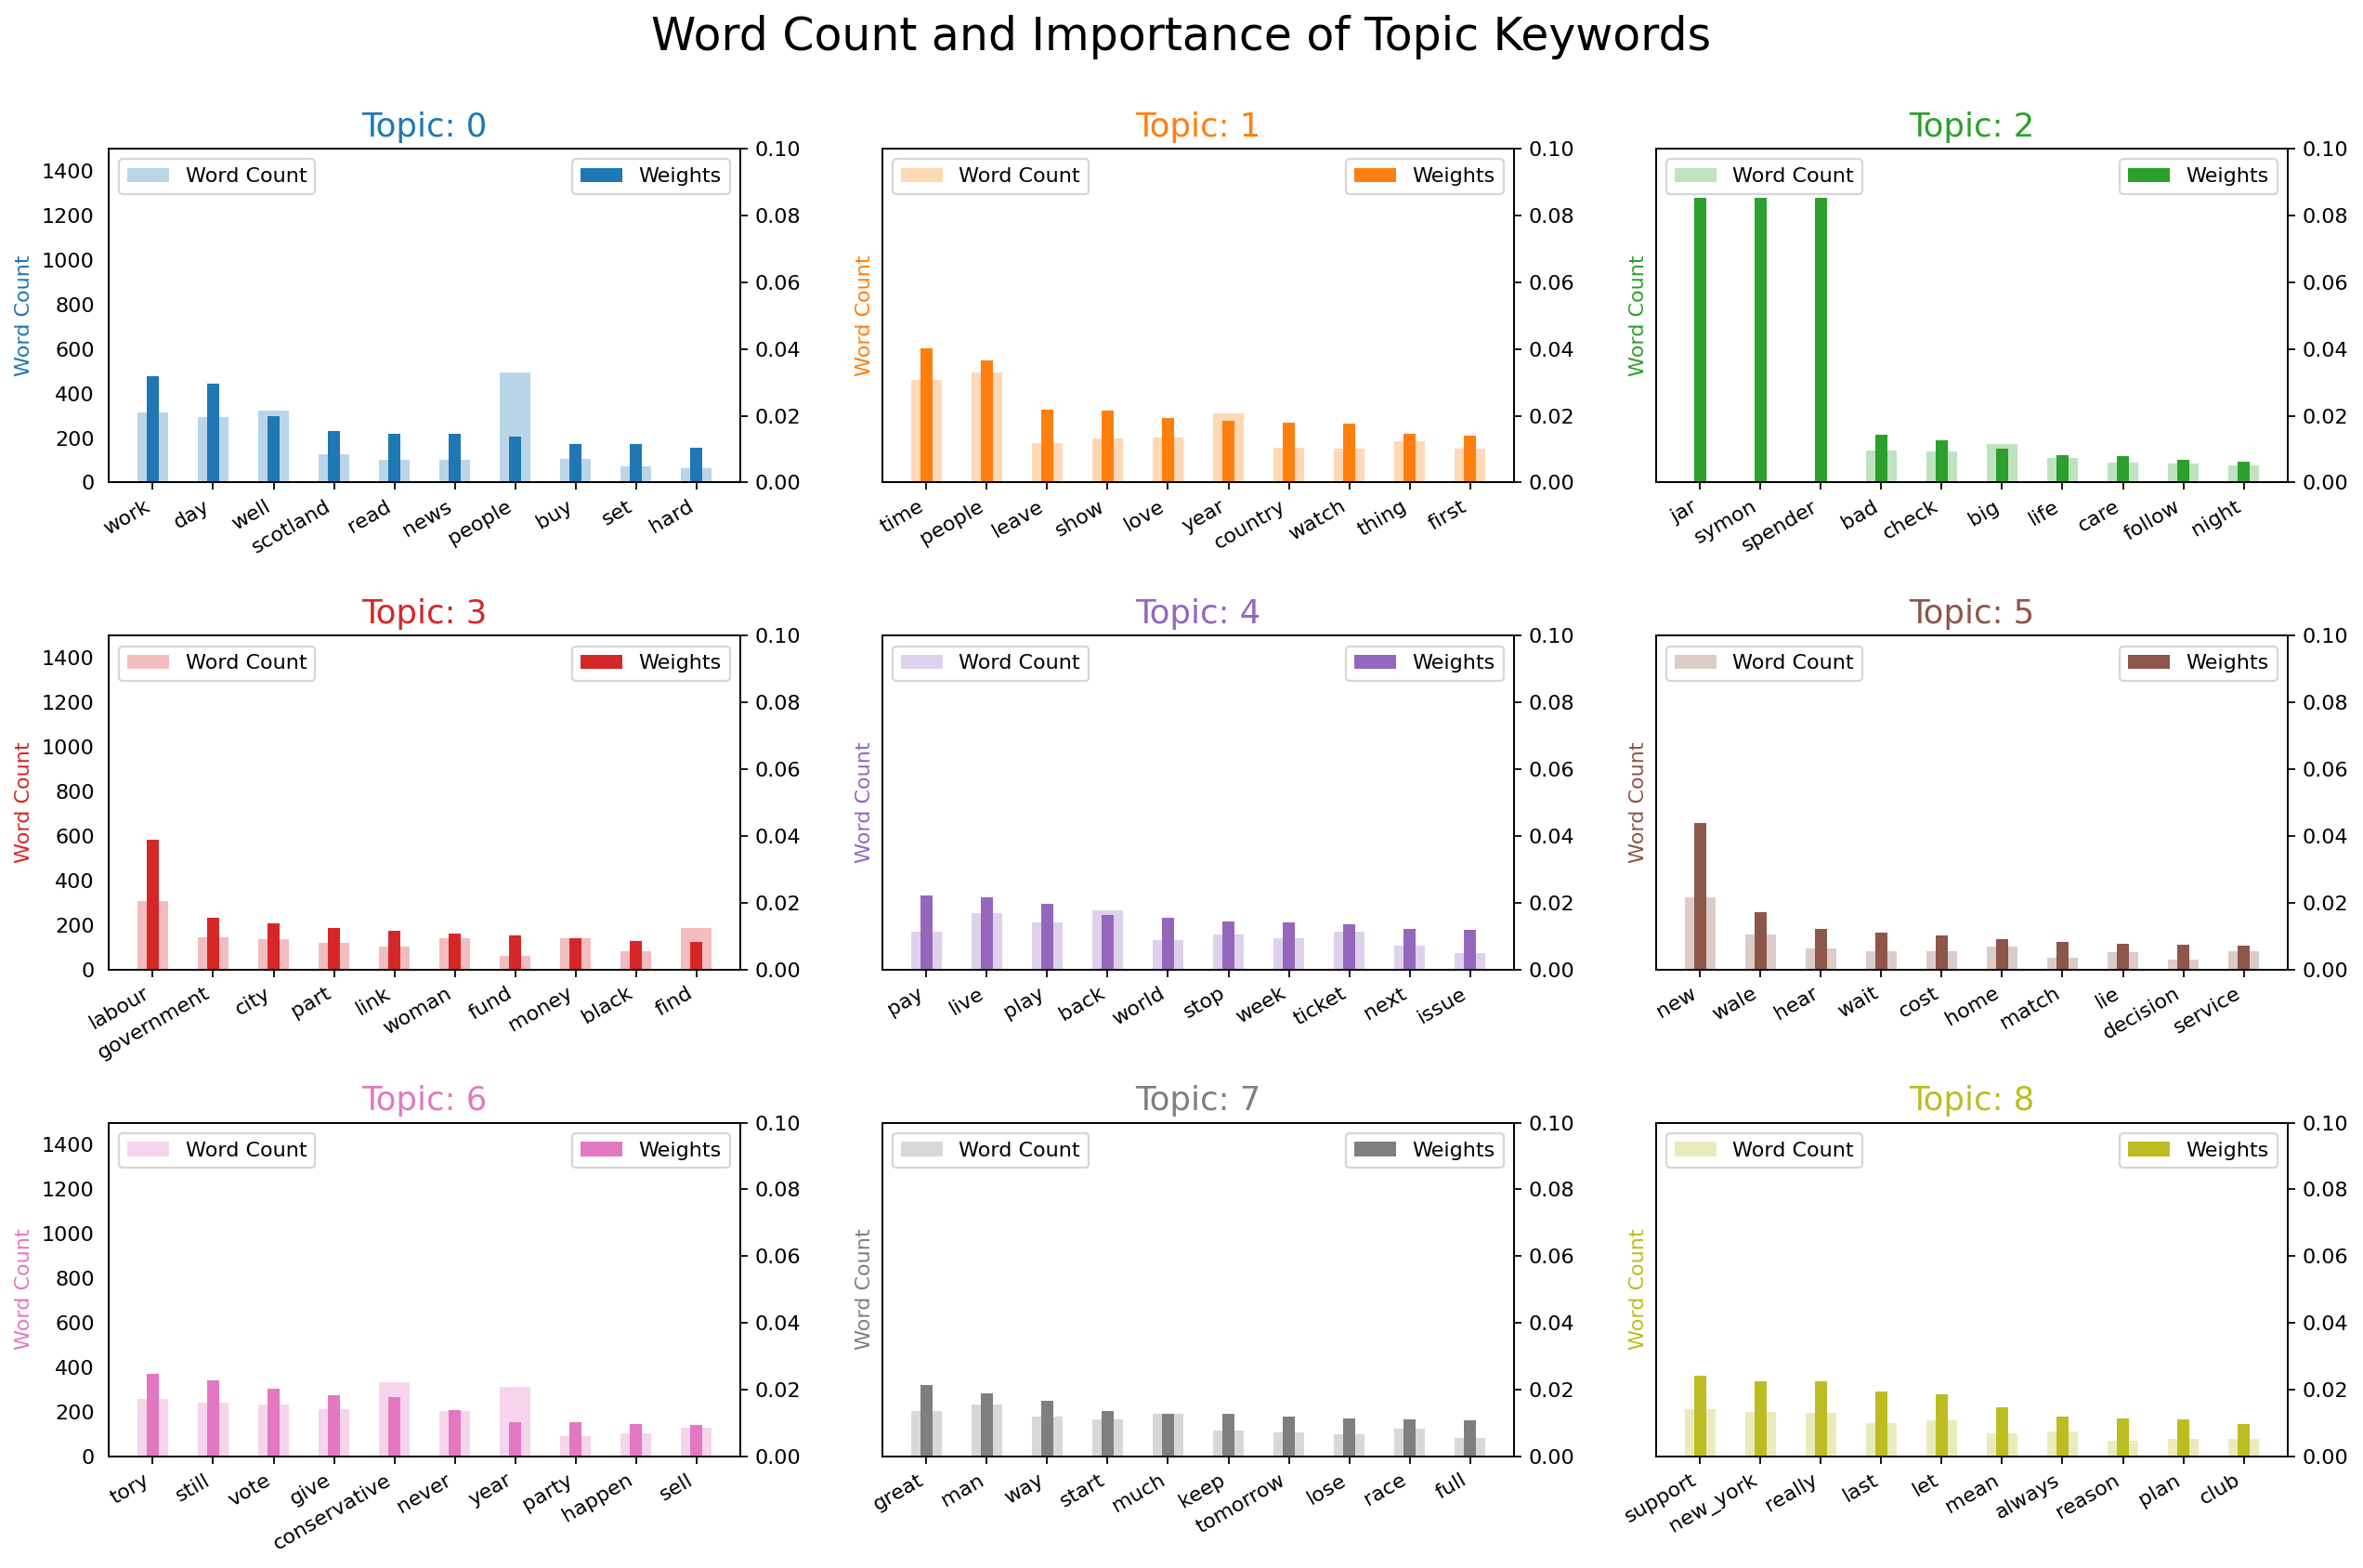

In [ ]:
from collections import Counter
topics = tweetsModel.show_topics(formatted=False)
data_flat = [w for w_list in processedTweets for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywordscff
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.100); ax.set_ylim(0, 1500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

<Axes: >

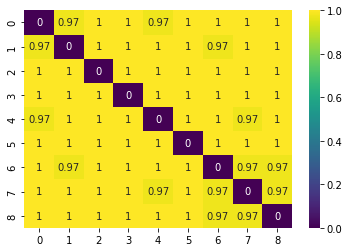

In [ ]:
import seaborn as sns
import numpy as np

# Get the top 10 terms for each topic
num_terms = 20
top_terms = [tweetsModel.get_topic_terms(topic_id, topn=num_terms) for topic_id in range(tweetsModel.num_topics)]

# Calculate Jaccard distances between topics
distances = np.zeros((tweetsModel.num_topics, tweetsModel.num_topics))
for i in range(tweetsModel.num_topics):
    for j in range(tweetsModel.num_topics):
        if i == j:
            continue
        set1 = set([term for term, _ in top_terms[i]])
        set2 = set([term for term, _ in top_terms[j]])
        distances[i][j] = 1 - len(set1.intersection(set2)) / len(set1.union(set2))

# Create heatmap using seaborn
sns.heatmap(distances, cmap='viridis', annot=True)

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis.gensim
#ldamodel=improvedtweetsModel, corpus=grptweetCorpus, texts=processedGroupedTweets
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(tweetsModel, tweetCorpus, dictionary=tweetsModel.id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.089122 -0.287159       1        1  13.005297
7      0.079207  0.001892       2        1  12.354382
4      0.019031  0.188308       3        1  11.824500
1      0.096339 -0.027925       4        1  11.804577
0      0.044052  0.090090       5        1  10.689596
8      0.031774 -0.047368       6        1  10.481720
3      0.006527  0.063922       7        1  10.474999
2     -0.357028 -0.062737       8        1  10.299153
5     -0.009024  0.080977       9        1   9.065775, topic_info=          Term        Freq       Total Category  logprob  loglift
3583       jar  667.000000  667.000000  Default  30.0000  30.0000
12804    symon  666.000000  666.000000  Default  29.0000  29.0000
12803  spender  666.000000  666.000000  Default  28.0000  28.0000
320       time  361.000000  361.000000  Default  27.0000  27.0000
12         new  302.000000  302.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
959     former   30.295452   31.113967   Topic9  -5.4245   2.3740
2641      beat   30.290478   31.109131   Topic9  -5.4247   2.3740
3362     house   30.220880   31.039244   Topic9  -5.4270   2.3739
9         else   30.024954   30.843526   Topic9  -5.4335   2.3738
69        head   37.009670   55.385414   Topic9  -5.2243   1.9975

[323 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1165      1  0.994001        able
121       7  0.982960  absolutely
42        5  0.976711      action
720       1  0.981795    actually
282       4  0.989067         add
...     ...       ...         ...
41        1  0.375447        year
41        4  0.623243        year
3225      9  0.968903   yesterday
531       4  0.975275         yet
991       5  0.977764       young

[303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 5, 2, 1, 9, 4, 3, 6])

In [ ]:

# Calculate Perplexity
perplexity = tweetsModel.log_perplexity(tweetCorpus)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
print(perplexity)
print(2**(-perplexity))

-9.83039438804859
910.4237530975341


In [ ]:
# Calculate Coherence Score
coherence_model_lda = CoherenceModel(model=tweetsModel, texts=processedTweets, dictionary=wordDictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(coherence_score)

0.344203104903108


In [ ]:
print(np.average(tweetsModel.diff(tweetsModel)[0]))

0.7460861361195418


# Loading 'group' tweet data
### Display the first 5 records.
### Also print the shape of dataframe.

In [ ]:
#Import tweets dataset local
#newTweets = pd.read_csv('./tweets/groupedTweets.csv')

#Import group dataset from google drive (google colab)
from google.colab import drive
drive.mount('/content/drive')
newTweets = pd.read_csv('/content/drive/My Drive/tweets/groupedTweets.csv')
print(newTweets.shape)
newTweets.head()

Mounted at /content/drive
(9968, 6)


group              tweetID        username  \
0      0  1621600585291014145   realJackEason   
1      0  1621600597127331842          battez   
2      0  1621600609030782981    Reno_station   
3      0  1621600638256693252     pedrinho_uk   
4      0  1621600792812609541  ClimateSchmidt   

                                                text    qScore    nScore  
0  @pansexualflower Criterion certainly have US r...  0.613271  2.934114  
1  @StratAnalytica @EconguyRosie yeah I'm in UK j...  0.603617  1.712620  
2  @NappaBald66 Dry clean eraser should do the tr...  0.669598  3.165340  
3  @alanvibe @DrHoenderkamp @haringeycouncil @mik...  0.543737  3.485828  
4  @PGDynes Climate change is a real problem, but...  0.609599  1.870719

group                                               text  text_length
0      0  @pansexualflower Criterion certainly have US r...         6563
1      1  🇨🇳 🇺🇸 #China\n#Chinese #Foreign #Ministry said...         3687
2      2  “As they began to understand the children’s op...        14152
3      3  Excess Deaths Skyrocket Again In England And W...        54365
4      4  @altgirlalterego scotland, seychelles, syria, ...         9953
5      5  Horse Racing History: Today in Racing 4th Febr...        18573
6      6  @dominos ridiculous service from your store. R...         2116
7      7  Check out Snake Eyes DVD (2021) https://t.co/B...        19294
8      8  de Jouvenel's Sovereignty (1957) has a fable a...        10401
9      9  They break the law with impunity, and have no ...         8580

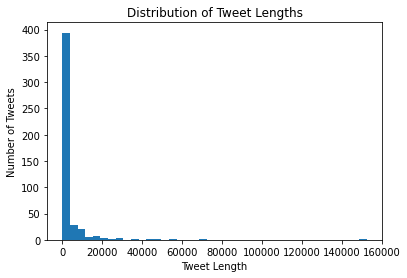

In [ ]:
combinedTweets = newTweets.groupby(['group'])['text'].apply(lambda x: ' '.join(x)).reset_index()
combinedTweets['text_length'] = combinedTweets['text'].str.len()
display(combinedTweets.head(10))
plt.hist(combinedTweets['text_length'], bins=40)
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweet Lengths')
plt.show()
# newTweets['cleanText'] = newTweets['text'].apply(clean_tweet)
# newTweets['tokens'] = newTweets['cleanText'].apply(tokenize_tweet)
# combinedTweets['tokens'] = combinedTweets['text'].apply(lambda x: display(x))
# display(groupedTweets)

In [ ]:
grpStats = combinedTweets['text_length'].describe().round(2)
display(grpStats)

count       471.00
mean       3235.56
std       10102.88
min          31.00
25%         189.50
50%         594.00
75%        1922.50
max      152602.00
Name: text_length, dtype: float64

In [ ]:
groupedtext = combinedTweets.text.values.tolist()
groupedtextWords = list(sent_to_words(groupedtext))
print(groupedtextWords[:1])

[['criterion', 'certainly', 'have', 'us', 'rights', 'to', 'the', 'restoration', 'but', 'very', 'unlikely', 'they', 'have', 'any', 'claim', 'to', 'uk', 'uhd', 'rights', 'alone', 'this', 'seems', 'more', 'like', 'cost', 'analysis', 'decision', 'by', 'the', 'bfi', 'or', 'else', 'they', 'determined', 'the', 'new', 'restoration', 'doesnt', 'merit', 'for', 'home', 'release', 'which', 'would', 'be', 'odd', 'yeah', 'im', 'in', 'uk', 'just', 'realised', 'this', 'context', 'and', 'it', 'all', 'seems', 'bit', 'sus', 'now', 'maybe', 'an', 'accounting', 'fudge', 'from', 'prev', 'month', 'to', 'create', 'this', 'month', 'hopefully', 'someone', 'qualified', 'will', 'look', 'into', 'it', 'dry', 'clean', 'eraser', 'should', 'do', 'the', 'trick', 'as', 'doesnt', 'look', 'to', 'bad', 'crumbly', 'for', 'heavier', 'stains', 'jean', 'bleed', 'etc', 'pal', 'in', 'my', 'area', 'emergency', 'services', 'amp', 'thames', 'water', 'had', 'problems', 'accessing', 'roads', 'because', 'or', 'roadblock', 'ltn', 'seem

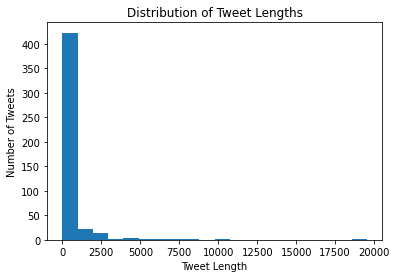

In [ ]:
newprocessedTokens = [len(doc) for doc in groupedtextWords]

plt.hist(pd.DataFrame(newprocessedTokens), bins=20)
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweet Lengths')
plt.show()

In [ ]:
#Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.
# Build the bigram and trigram models
bigram = gensim.models.Phrases(groupedtextWords, min_count=2, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[groupedtextWords], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

import en_core_web_sm
nlp = en_core_web_sm.load()

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
   # nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

/usr/local/lib/python3.9/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
processedGroupedTweets = process_words(groupedtextWords)

In [ ]:
print((processedGroupedTweets))

[['criterion', 'certainly', 'restoration', 'unlikely', 'claim', 'alone', 'cost', 'analysis', 'decision', 'bfi', 'else', 'determine', 'new', 'restoration', 'merit', 'home', 'release', 'odd', 'realise', 'context', 'bit', 'sus', 'maybe', 'account', 'fudge', 'prev', 'month', 'create', 'month', 'hopefully', 'qualify', 'dry', 'clean', 'eraser', 'trick', 'bad', 'crumbly', 'heavy', 'stain', 'area', 'thame', 'water', 'problem', 'access', 'road', 'problem', 'location', 'climate_change', 'real', 'problem', 'claim', 'earth', 'uninhabitable', 'soon', 'accurately', 'represent', 'current', 'state', 'scientific', 'knowledge', 'detail', 'matter', 'serious', 'problem', 'overstate', 'sister', 'work', 'honestly', 'precious', 'omg', 'relevant', 'dorrie', 'mcvey', 'jacob_ree', 'mogg', 'miss', 'pig', 'fly', 'sunak', 'health', 'forward', 'please', 'give', 'visa', 'responsibility', 'wish', 'send', 'peace', 'god_bless', 'point', 'scream', 'inclusion', 'hate', 'rugby', 'leave', 'south', 'wale', 'instance', 'adap

In [ ]:
# Create Dictionary
wordDictionary = corpora.Dictionary(processedGroupedTweets)
print(len(wordDictionary))
# Create Corpus: Term Document Frequency
grptweetCorpus = [wordDictionary.doc2bow(text) for text in processedGroupedTweets]

c=[]
p=[]
group_kld =[]
for t in range(1,25):
  # Build LDA model
  print(t)
  improvedtweetsModel = gensim.models.ldamodel.LdaModel(corpus=grptweetCorpus,
                                            id2word=wordDictionary,
                                            num_topics=t,
                                            random_state=5000,
                                            update_every=1,
                                            chunksize=100,
                                            passes=30,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)
  coherence_model_lda = CoherenceModel(model=improvedtweetsModel, texts=processedGroupedTweets, dictionary=wordDictionary, coherence='c_v')
  coherence_score = coherence_model_lda.get_coherence()
  c.append(coherence_score)
  perplexity = improvedtweetsModel.log_perplexity(grptweetCorpus)
  p.append(2**(-perplexity))
  group_kld.append(np.average(improvedtweetsModel.diff(improvedtweetsModel)[0]))

12796
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


[0.3175857260503564, 0.3171728256045613, 0.3877134341326352, 0.3249300857337262, 0.35609499069810224, 0.3609891407053958, 0.4081978921223284, 0.3686142823208801, 0.37777521668748526, 0.4164406179955842, 0.37470596885933405, 0.37338881598930324, 0.3758076702918064, 0.3882546555514903, 0.39795394457364236, 0.39572701160841023, 0.4148383735907499, 0.4157913408766925, 0.4063987416743152, 0.41123797809237816, 0.4080859232114591, 0.40491057674449027, 0.4285092212800333, 0.4020811960748027]


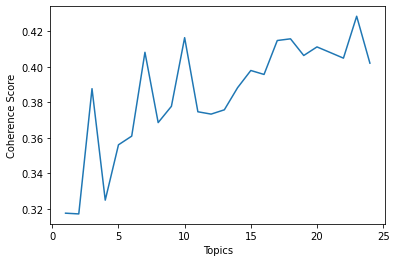

In [ ]:
plt.plot(range(1,25), c)
plt.xlabel("Topics")
plt.ylabel("Coherence Score")
print(c)

Text(0, 0.5, ' perplexity')

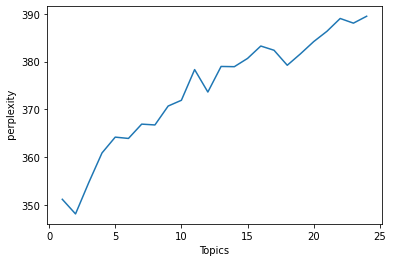

In [ ]:
plt.plot(range(1,25), p)
plt.xlabel("Topics")
plt.ylabel(" perplexity")

Text(0, 0.5, 'KL Divergence')

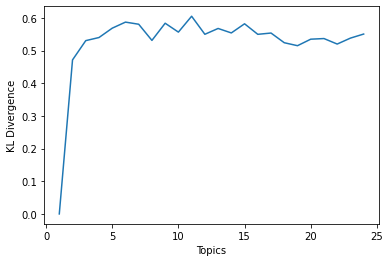

In [ ]:
plt.plot(range(1,25), group_kld)
plt.xlabel("Topics")
plt.ylabel("KL Divergence")

In [ ]:
improvedtweetsModel = gensim.models.ldamodel.LdaModel(corpus=grptweetCorpus,
                                            id2word=wordDictionary,
                                            num_topics=10,
                                            random_state=5000,
                                            update_every=1,
                                            chunksize=100,
                                            passes=30,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)
# print all topics
improvedtweetsModel.show_topics()

# print topic
improvedtweetsModel.print_topic(-1, topn=20)

# and another way, only prints top words
for t in range(0, improvedtweetsModel.num_topics-1):
    print(  'topic {}: '.format(t) + ', '.join([str(v[1]) for v in improvedtweetsModel.show_topic(t, 20)]))

topic 0: 0.032039393, 0.016671134, 0.011535064, 0.010850067, 0.008554852, 0.0063238735, 0.0059341183, 0.004618151, 0.004463848, 0.004257281, 0.004246398, 0.0041352087, 0.0040065236, 0.003961916, 0.0039211926, 0.0038164912, 0.003641032, 0.003431565, 0.0034151927, 0.0033414306
topic 1: 0.033941496, 0.0067007747, 0.0047327066, 0.0039966865, 0.0029073793, 0.0027125345, 0.0026743666, 0.00258972, 0.002573804, 0.002524551, 0.0025020512, 0.0024651682, 0.002396751, 0.00224116, 0.0022338193, 0.002201801, 0.0021946332, 0.0021867277, 0.0021767612, 0.0021704503
topic 2: 0.01721352, 0.014614183, 0.014239376, 0.0137562165, 0.013318687, 0.0023999624, 0.0023644152, 0.0019782311, 0.0018334636, 0.0018097522, 0.0018097481, 0.0017591702, 0.0016343767, 0.0015932067, 0.0015146567, 0.0015146567, 0.001514651, 0.0014945797, 0.0014848035, 0.0014209222
topic 3: 0.0577552, 0.014486553, 0.0030982278, 0.003054975, 0.0029524365, 0.0028804436, 0.002799967, 0.0025483419, 0.0024934993, 0.0024546494, 0.002446556, 0.00244

In [ ]:
grp_tweet_topic_sents_keywords = format_topics_sentences(ldamodel=improvedtweetsModel, corpus=grptweetCorpus, texts=processedGroupedTweets)

# Format
grp_tweet_dominant_topic = grp_tweet_topic_sents_keywords.reset_index()
grp_tweet_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
grp_tweet_dominant_topic.head(10)

<ipython-input-3-aefd7c72c831>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-3-aefd7c72c831>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               7              0.4616   
1            1               4              0.9949   
2            2               4              0.6410   
3            3               7              0.7679   
4            4               0              0.9970   
5            5               4              0.7453   
6            6               0              0.3750   
7            7               1              0.3694   
8            8               0              0.4162   
9            9               7              0.8962   

                                            Keywords  \
0  conservative, year, work, still, well, never, ...   
1  new, love, new_york, find, wale, back, city, t...   
2  new, love, new_york, find, wale, back, city, t...   
3  conservative, year, work, still, well, never, ...   
4  labour, tory, vote, worker, pay, union, work, ...   
5  new, love, new_york, find, wale, back, city, t...   
6  labour, tory, vote, worker, pay, union, work, ...   
7  people, government, case, service, rapist, mat...   
8  labour, tory, vote, worker, pay, union, work, ...   
9  conservative, year, work, still, well, never, ...   

                                                Text  
0  [criterion, certainly, restoration, unlikely, ...  
1  [weather, deviate, course, military, threat, n...  
2  [begin, understand, child, operational, scheme...  
3  [excess_death, death, excess_death, register, ...  
4  [seychelle, instead, worker, corner, india_asi...  
5  [horse_race, history, today, race, day, horse_...  
6  [ridiculous, service, store, remember, order, ...  
7  [check, eye, etsy_shop, often, wonder, explore...  
8  [fable, city, metaphysical, foundation, gradua...  
9  [break, law, impunity, shame, hunt, act, union...

471


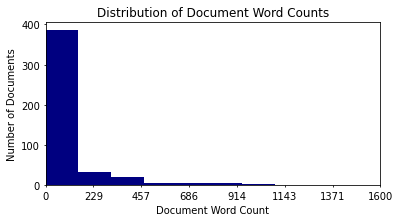

In [ ]:
doc_lens = [len(d) for d in grp_tweet_dominant_topic.Text]
print(len(doc_lens))
# Plot
plt.figure(figsize=(6,3))
plt.hist(doc_lens,bins=40, color='navy')

plt.gca().set(xlim=(0, 1600), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=2)
plt.xticks(np.linspace(0,1600,8))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=12))
plt.show()

<ipython-input-30-55c333571085>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-30-55c333571085>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-30-55c333571085>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-30-55c333571085>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, col

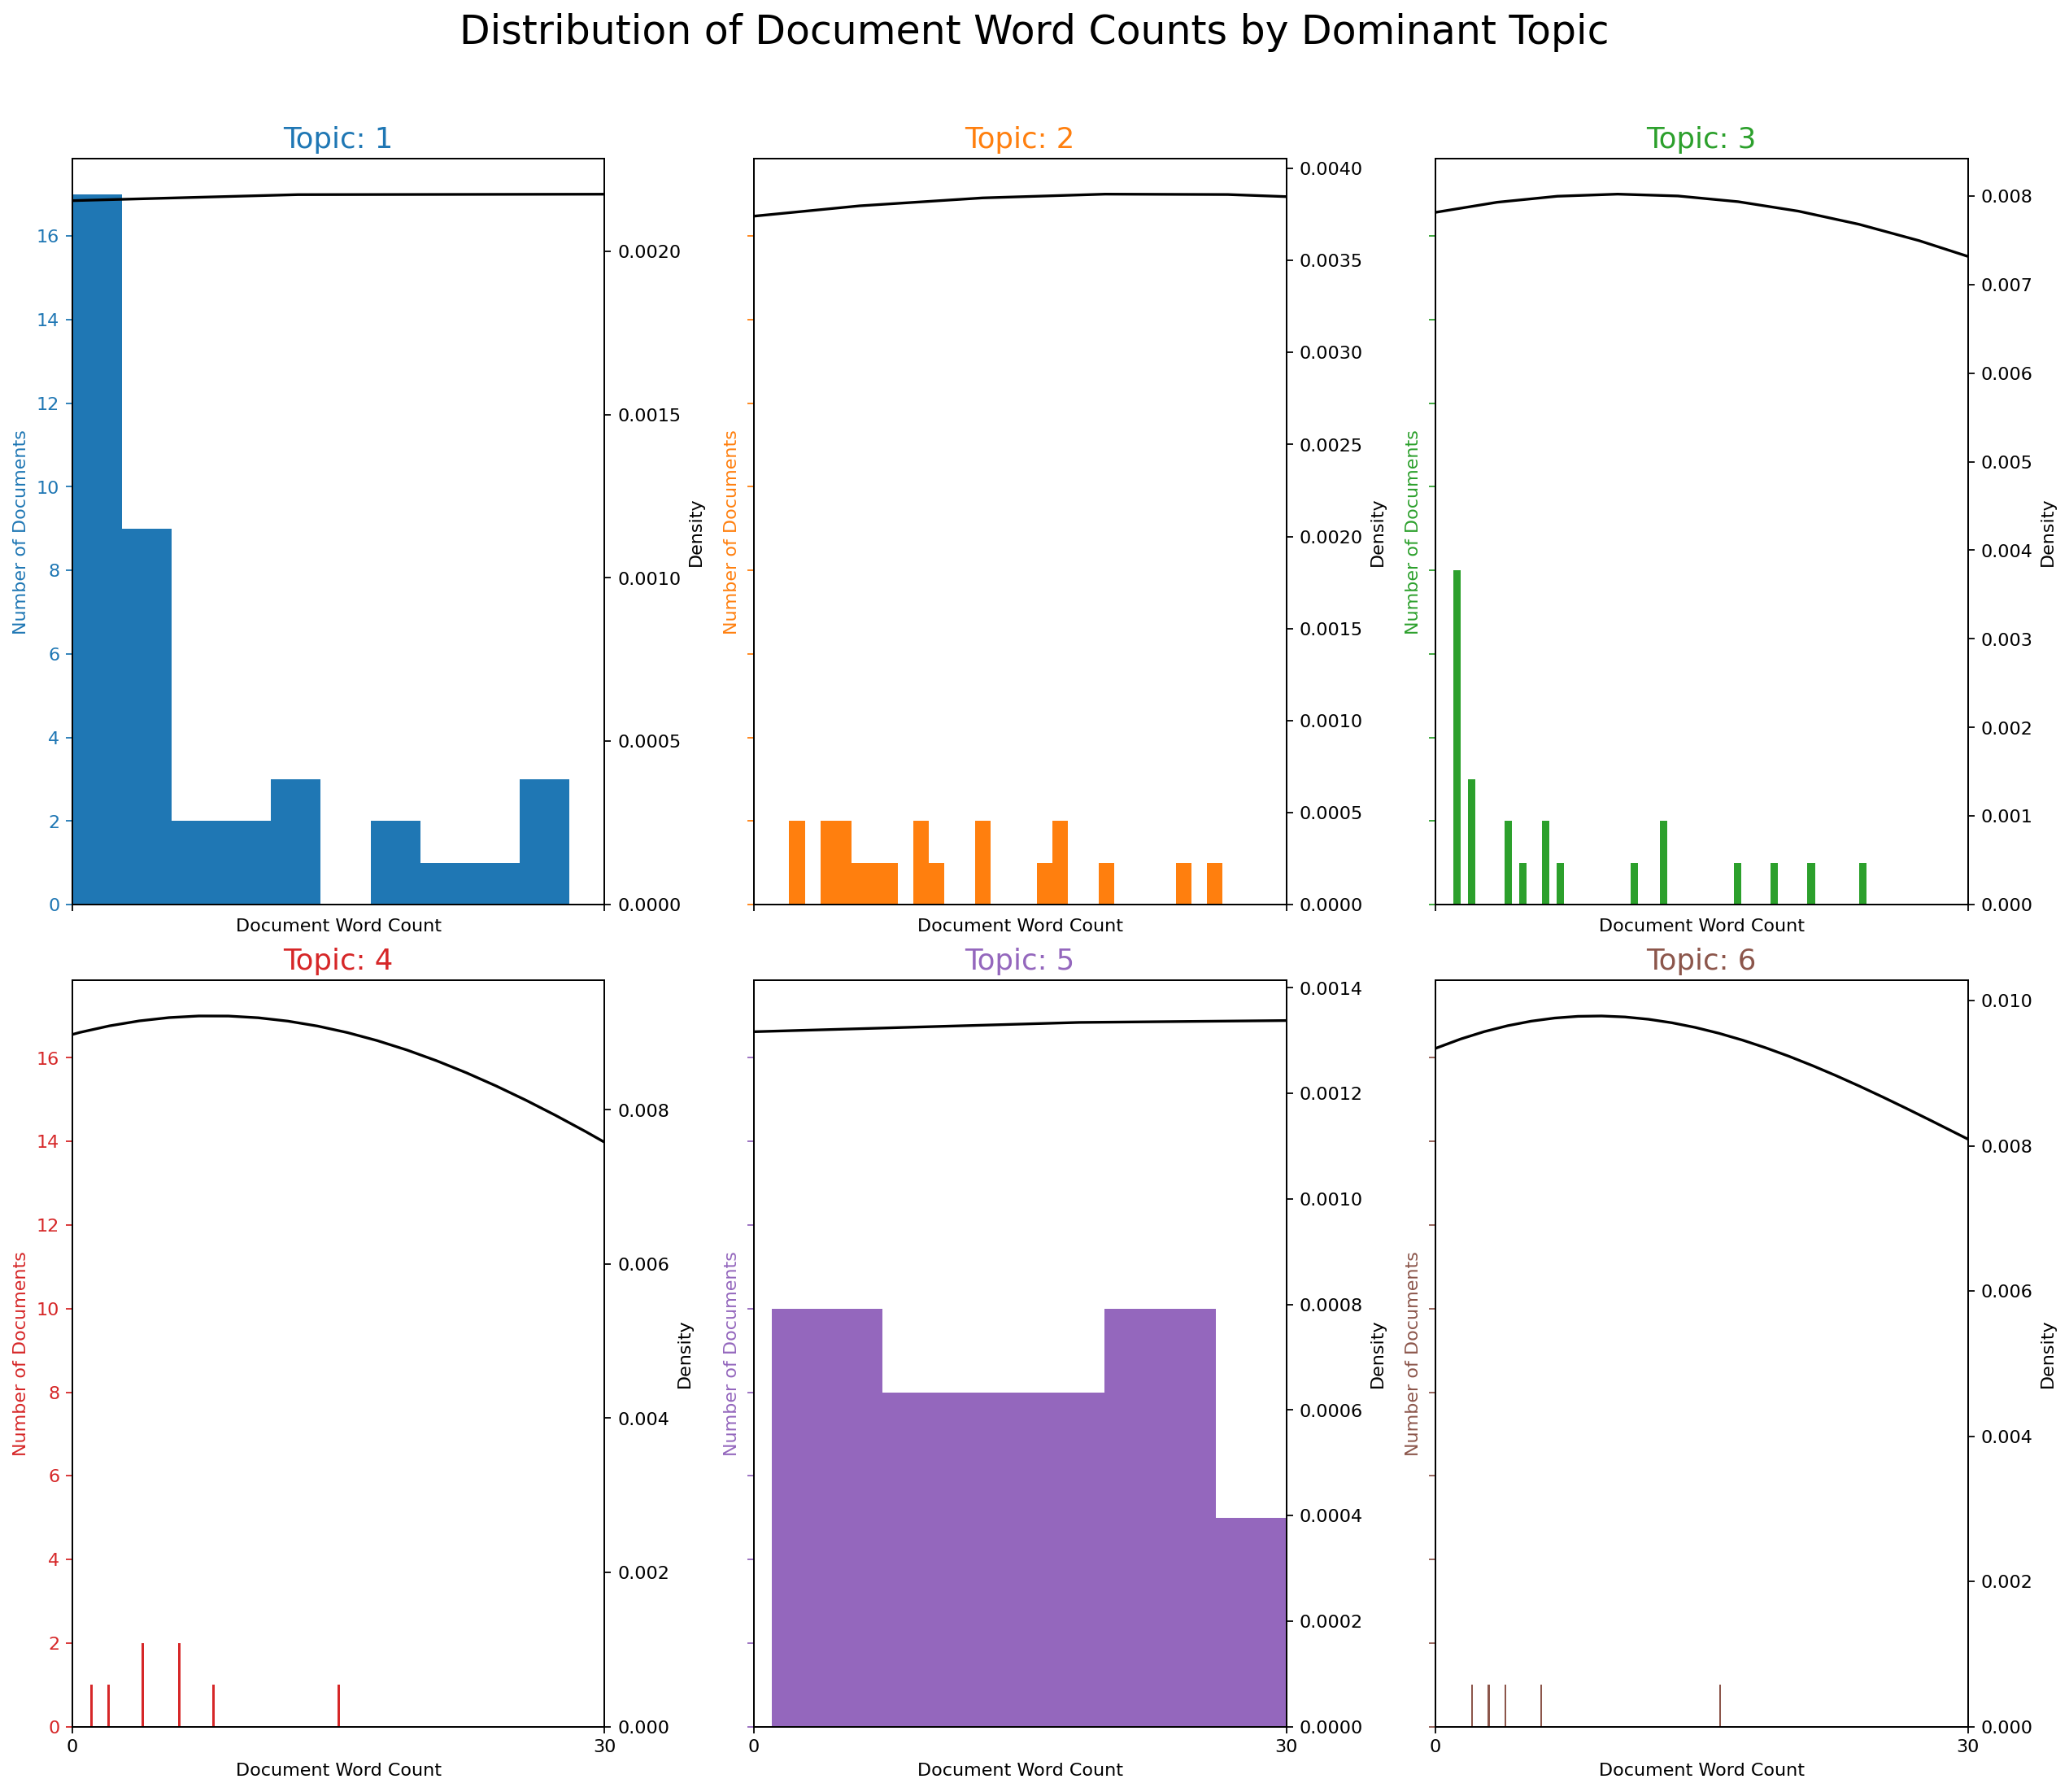

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    new_tweet_dominant_topic_sub = grp_tweet_dominant_topic.loc[grp_tweet_dominant_topic.Dominant_Topic == i, :]
    print
    # display(new_tweet_dominant_topic_sub)
    doc_lens = [len(d) for d in new_tweet_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 20), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i+1), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,30,2))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

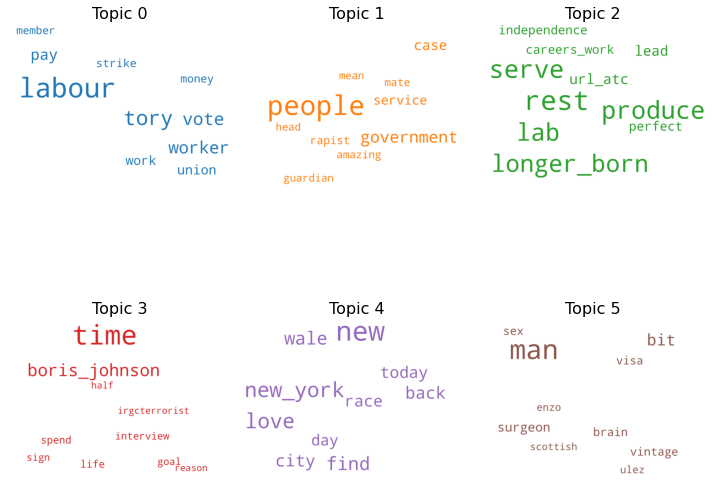

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = improvedtweetsModel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<ipython-input-24-723a1dbb6031>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


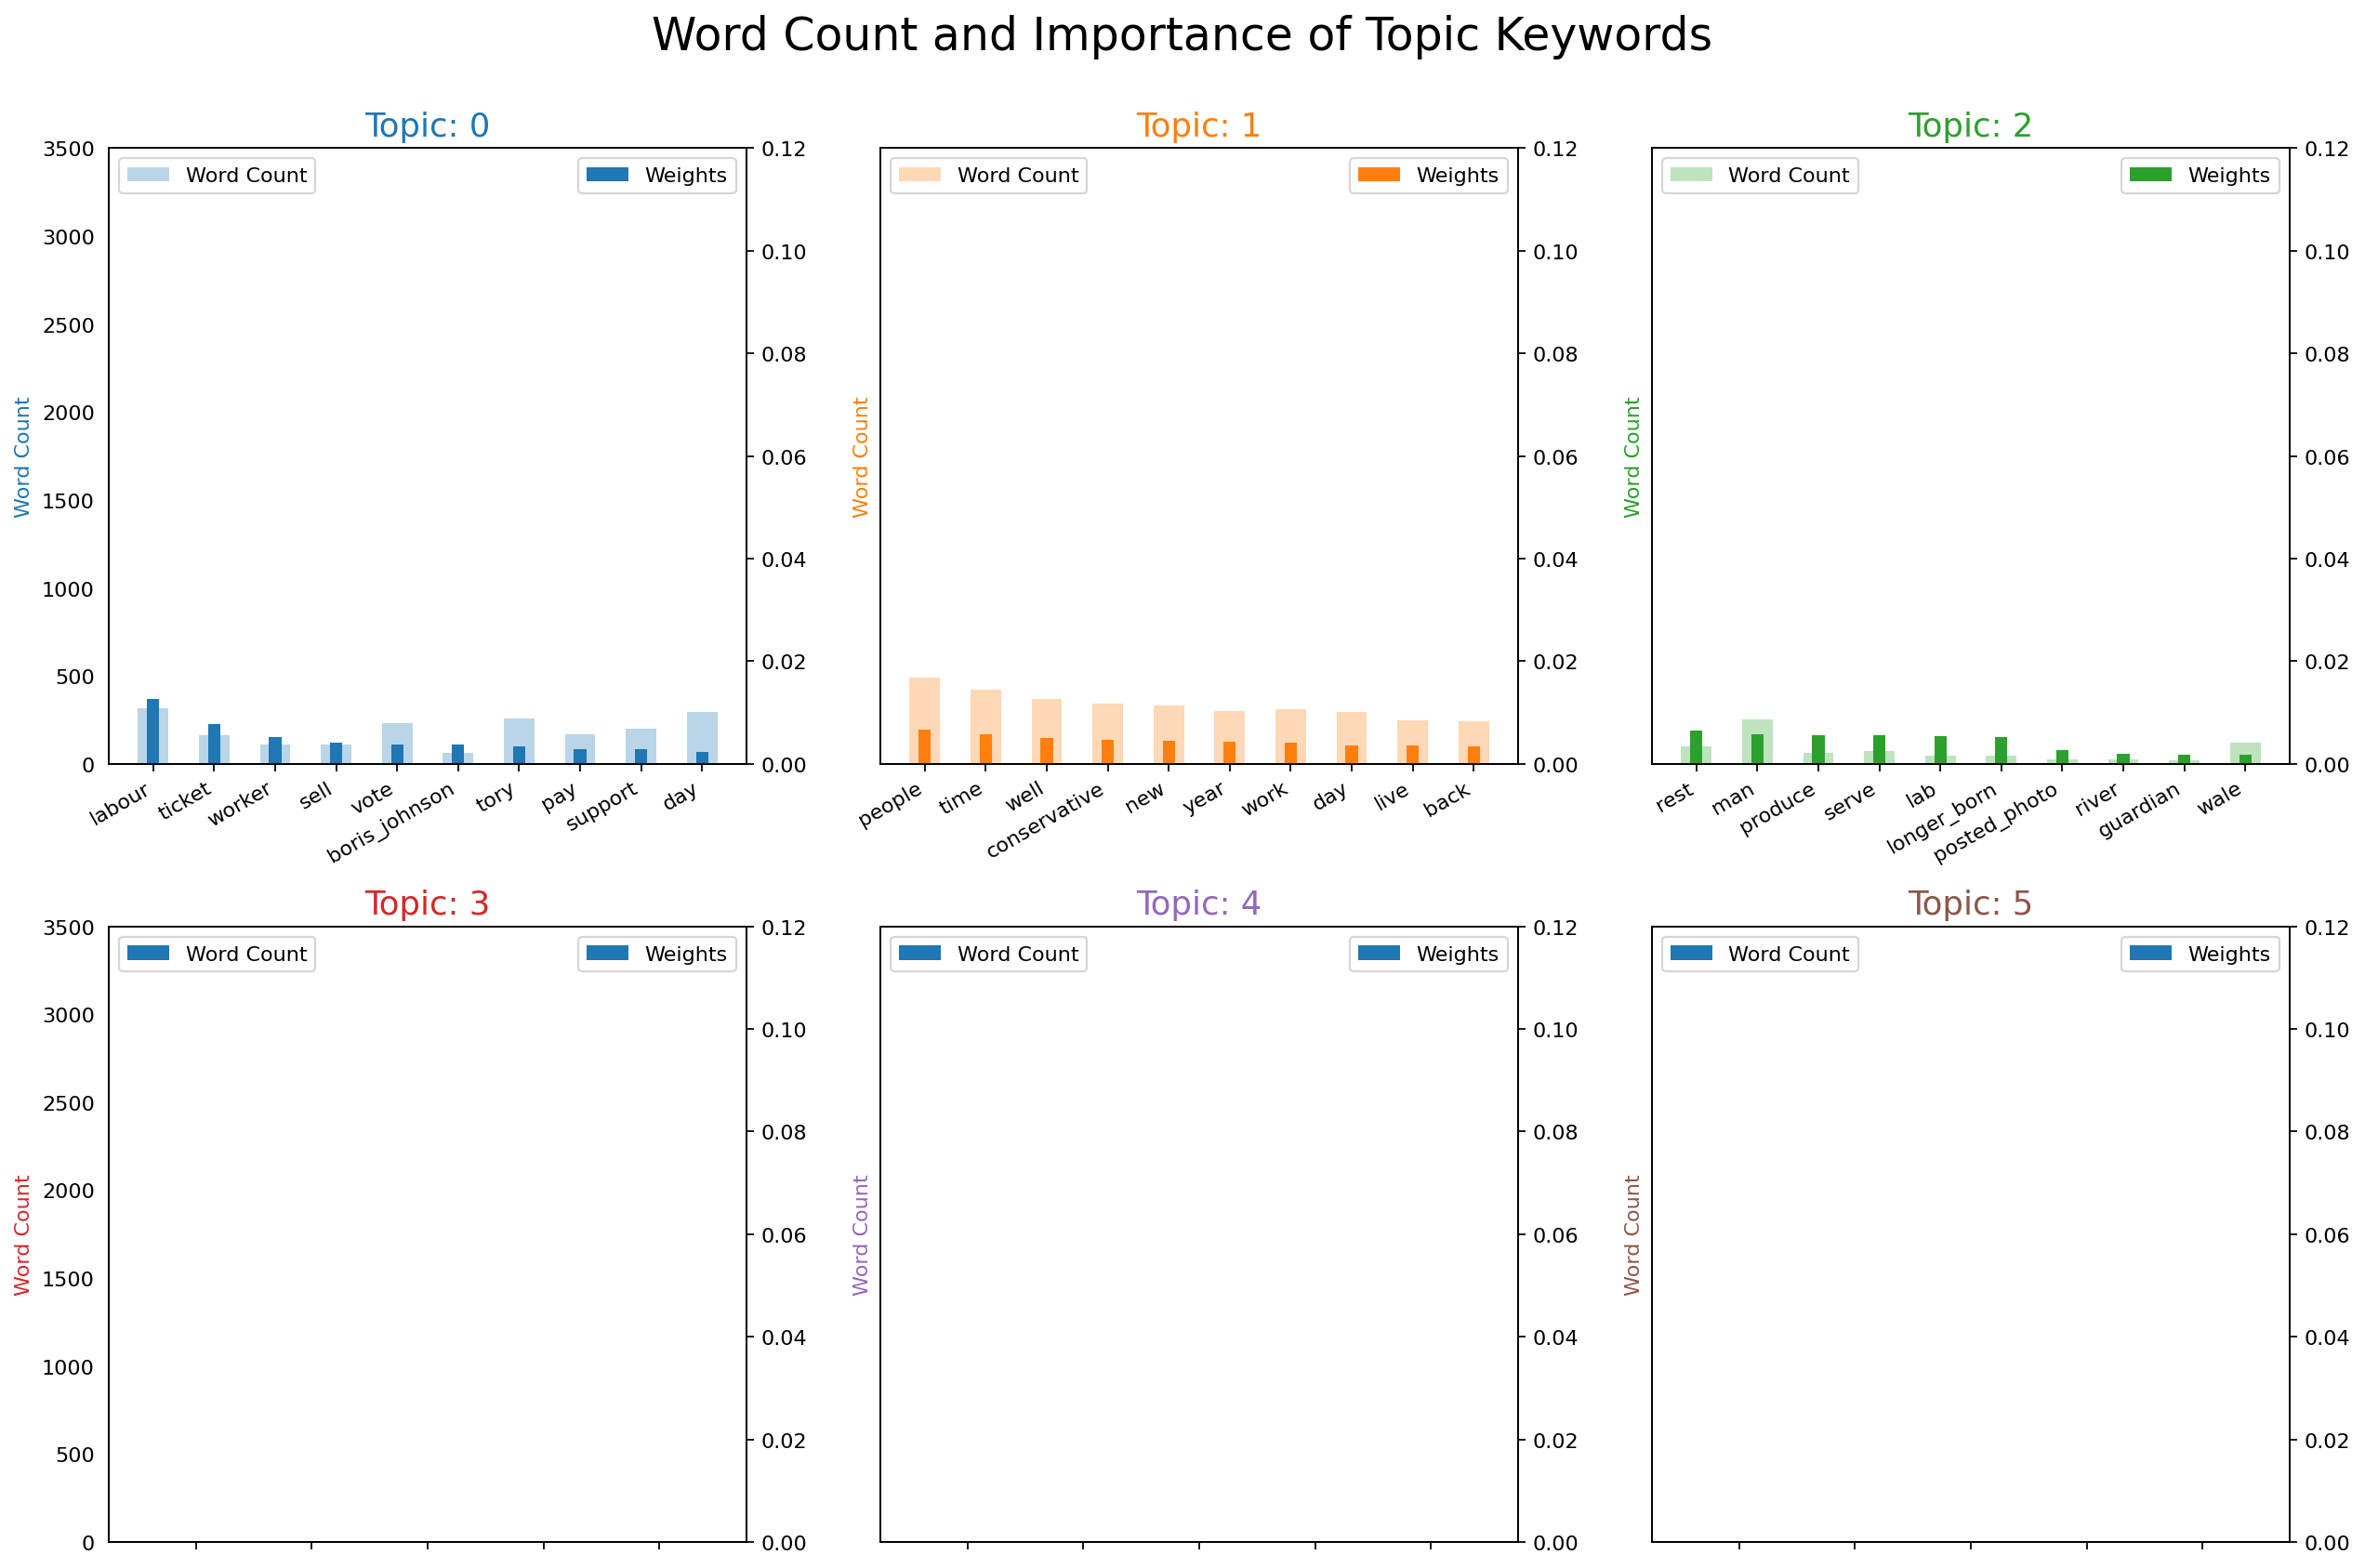

In [ ]:
from collections import Counter
topics = improvedtweetsModel.show_topics(formatted=False)
data_flat = [w for w_list in processedGroupedTweets for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.120); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 31.5 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [ ]:
import pyLDAvis.gensim
#ldamodel=improvedtweetsModel, corpus=grptweetCorpus, texts=processedGroupedTweets
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(improvedtweetsModel, grptweetCorpus, dictionary=improvedtweetsModel.id2word)
vis

ModuleNotFoundError: ignored

<Axes: >

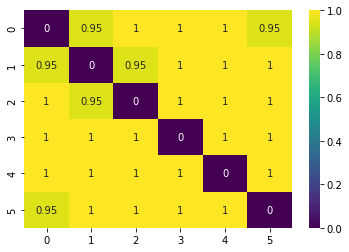

In [ ]:
import seaborn as sns
import numpy as np

# Get the top 10 terms for each topic
num_terms = 10
top_terms = [improvedtweetsModel.get_topic_terms(topic_id, topn=num_terms) for topic_id in range(improvedtweetsModel.num_topics)]

# Calculate Jaccard distances between topics
distances = np.zeros((improvedtweetsModel.num_topics, improvedtweetsModel.num_topics))
for i in range(improvedtweetsModel.num_topics):
    for j in range(improvedtweetsModel.num_topics):
        if i == j:
            continue
        set1 = set([term for term, _ in top_terms[i]])
        set2 = set([term for term, _ in top_terms[j]])
        distances[i][j] = 1 - len(set1.intersection(set2)) / len(set1.union(set2))

# Create heatmap using seaborn
sns.heatmap(distances, cmap='viridis', annot=True)

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=improvedtweetsModel, corpus=grptweetCorpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in improvedtweetsModel.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

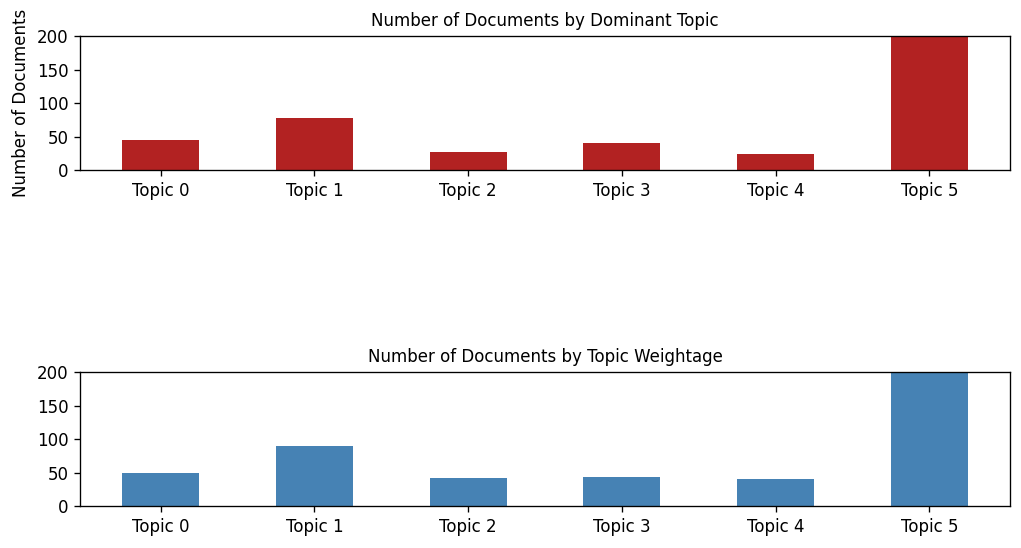

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), dpi=120, sharey=True)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic '+ str(x))   # + '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0]
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
# Calculate Perplexity
perplexity = improvedtweetsModel.log_perplexity(grptweetCorpus)
print('Perplexity: ',2**(-perplexity))
print(perplexity)

/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Perplexity:  364.23094303324547
-8.508709680635107


/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
print(perplexity)
print(2**(-perplexity))

-8.508709680635107
364.23094303324547


In [ ]:


coherence_model_lda = CoherenceModel(model=improvedtweetsModel, texts=processedGroupedTweets, dictionary=wordDictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_score)

Coherence Score:  0.3850492113176236


In [ ]:
print(np.average(improvedtweetsModel.diff(improvedtweetsModel)[0]))

0.5721434539251086
